### Présentation du cas d'usage de substitution de produits

Le projet consiste à développer un outil  pour recommander aux clients d'Intermarché le produit de substitution le plus pertinent lors de leur achat. Cela vise à améliorer l'expérience d'achat en proposant des alternatives de produits qui répondent aux préférences des clients et à leurs exigences nutritionnelles si les produits initiaux ne sont pas disponibles ou en rupture de stock.

Les enjeux principaux sont :
- Proposer des alternatives appropriées en temps réel pendant le processus d'achat, ce qui peut contribuer à augmenter la satisfaction client et réduire le taux d'abandon.
- Favoriser la découverte de nouveaux produits et d'options gourmandes adaptées aux besoins des clients.

Les objectifs du projet sont :
- Analyser les données d'achat pour identifier les tendances et les préférences des clients.
- Développer un algorithme de recommandation produits de substitution qui prend en compte les critères nutritionnels et les préférences des clients.
- Intégrer l'outil de recommandation dans la plateforme E-commerce pour une utilisation en temps réel.

L'architecture de l'outil de recommandation des produits de substitution comprend 3 principales briques technologiques :
- Une brique de détection que le produit est en rupture en temps réel lors de l'achat.
- Une brique de sélection des produits candidats au sein de la même catégorie de produits.
- Une brique de scoring des produits candidats : c'est un modèle de classification qui, pour chaque couple (produit original, produit candidat), évalue la probabilité que le client accepte le produit candidat en substitution du produit initial

--> Dans ce notebook, nous nous concentrons sur cette dernière brique de scoring des produits candidats. Pour chaque couple (produit original, produit candidat), nous allons entraîner et évaluer des modèles de classification pour prédire la probabilité que le client accepte le produit candidat en substitution du produit original.

## 0. Import des packages et Import des données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.metrics import (
    roc_curve, auc, accuracy_score, roc_auc_score,
    precision_score, recall_score, f1_score
)
from catboost import CatBoostClassifier
import xgboost as xgb
import lightgbm as lgb
from hyperopt import fmin, tpe, Trials, STATUS_OK, hp

/home/eric/.cache/pypoetry/virtualenvs/algo-reco-Zao1WwXe-py3.12/lib/python3.12/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [ ]:
from pathlib import Path

def find_project_root(marker=".git"):
    """Remonte les dossiers jusqu'à trouver un fichier/dossier marqueur"""
    path = Path().resolve()
    while path != path.parent:
        if (path / marker).exists():
            return path
        path = path.parent
    raise FileNotFoundError(f"Project root with {marker} not found")

ROOT_DIR = find_project_root()
DATA_RAW_DIR = ROOT_DIR / "data" / "raw"

FILENAME_RAW_SUBSTITUTIONS = DATA_RAW_DIR / "substitutions" / "raw_substitutions_substitutions.csv"
FILENAME_RAW_PRODUITS = DATA_RAW_DIR / "produits" / "raw_produits_produits.csv"
FILENAME_RAW_TRANSACTIONS = DATA_RAW_DIR / "transactions" / "raw_transactions_transactions.csv"

substitutions = pd.read_csv(FILENAME_RAW_SUBSTITUTIONS)
produits = pd.read_csv(FILENAME_RAW_PRODUITS)
transactions = pd.read_csv(FILENAME_RAW_TRANSACTIONS)


In [11]:
substitutions.head()

,idTransaction,idProduitOriginal,idProduitSubstitution,estAcceptee
0,T24DD58BF,325083215285,325092304501,False
1,T38C29E8F,325041969315,325077014363,False
2,TC3AC30CC,325072081155,325073598933,True
3,TC9F04F18,325097289623,325034327560,True
4,TD0D8274D,325056289002,325082100996,False


In [12]:
produits.head()

,idProduit,libelle,categorie,marque,typeMarque,nutriscore,conditionnement,origine,estBio,prix
0,325000133890,Crème Fraîche Pâturages 20cl,Frais > Crémerie > Crème Fraîche,Pâturages,mdd,C,20cl,UE,False,0.95
1,325054235116,Shampoing Le Petit Marseillais 250ml,Hygiène > Corps > Shampoing,Le Petit Marseillais,national,NaN,250ml,UE,NaN,3.12
2,325049593103,Escalope Poulet Charal 4 filets (500g),Frais > Boucherie > Escalope Poulet,Charal,national,B,4 filets (500g),France,False,6.59
3,325034192832,Yaourt Nature Pâturages 4x125g,Frais > Crémerie > Yaourt Nature,Pâturages,mdd,B,4x125g,UE,False,1.24
4,325064139537,Lessive Liquide Ariel 1.5L,Hygiène > Maison > Lessive Liquide,Ariel,national,NaN,1.5L,France,NaN,10.19


In [13]:
transactions.head()

,idTransaction,dateHeureTransaction,idClient,idProduit,quantite
0,TB66422B8,2023-01-01 08:01:00,C000039,325013000413,1
1,TB66422B8,2023-01-01 08:01:00,C000039,325021044789,2
2,TB66422B8,2023-01-01 08:01:00,C000039,325044152982,1
3,TB66422B8,2023-01-01 08:01:00,C000039,325003091436,1
4,TB66422B8,2023-01-01 08:01:00,C000039,325074260880,1


## 1. Transformations des données

Architecture de la table cible 👉 Une ligne = une proposition de substitution faite à un client pour un produit donné lors d’une transaction.
Donc chaque ligne correspond à :
(Transaction, Produit original, Produit substitut, Accepté ou refusé)

Ce n’est pas un niveau produit, ni un niveau transaction 
→ c’est un niveau couple Original–Substitution.

### 1.1. Merge des données de substitutions avec les données des produits et des transactions

In [14]:
produits_original = produits.add_suffix('Original')
substitutions_produits_original = pd.merge(substitutions, produits_original, \
on='idProduitOriginal' , how ='left')
produits_substitution = produits.add_suffix('Substitution')
substitutions_produits_original_substitut = pd.merge(substitutions_produits_original, produits_substitution,\
    on='idProduitSubstitution' , how ='left')

In [15]:
transactions_avec_substitution = pd.merge(transactions, substitutions_produits_original_substitut, \
left_on=['idProduit', 'idTransaction'], right_on=['idProduitOriginal', 'idTransaction'], how='inner')
transactions_avec_substitution['estAcceptee_bin'] = [1 if x == False else 0 for x in transactions_avec_substitution['estAcceptee']]

In [16]:
transactions_avec_substitution.head()

,idTransaction,dateHeureTransaction,idClient,idProduit,quantite,idProduitOriginal,idProduitSubstitution,estAcceptee,libelleOriginal,categorieOriginal,...,libelleSubstitution,categorieSubstitution,marqueSubstitution,typeMarqueSubstitution,nutriscoreSubstitution,conditionnementSubstitution,origineSubstitution,estBioSubstitution,prixSubstitution,estAcceptee_bin
0,TB66422B8,2023-01-01 08:01:00,C000039,325074260880,1,325074260880,325044913421,False,BIO Eau Plate Vittel 1.5L,Boissons > Eaux > Eau Plate,...,Eau Plate Top Budget 6x1.5L,Boissons > Eaux > Eau Plate,Top Budget,premier_prix,A,6x1.5L,Hors UE,False,1.94,1
1,TB66422B8,2023-01-01 08:01:00,C000039,325096423536,1,325096423536,325092758955,False,Eau Plate Evian 1.5L,Boissons > Eaux > Eau Plate,...,Eau Plate San Pellegrino 6x50cl,Boissons > Eaux > Eau Plate,San Pellegrino,premium,A,6x50cl,France,False,4.70,1
2,TB66422B8,2023-01-01 08:01:00,C000039,325057992707,3,325057992707,325068970283,True,Yaourt Nature Yoplait 4x125g,Frais > Crémerie > Yaourt Nature,...,Yaourt Nature Top Budget 8x125g,Frais > Crémerie > Yaourt Nature,Top Budget,premier_prix,C,8x125g,UE,False,0.93,0
3,TB66422B8,2023-01-01 08:01:00,C000039,325065435884,1,325065435884,325040862118,False,Gel Douche Klorane 250ml,Hygiène > Corps > Gel Douche,...,Gel Douche Dove 500ml,Hygiène > Corps > Gel Douche,Dove,national,NaN,500ml,France,NaN,3.02,1
4,TB66422B8,2023-01-01 08:01:00,C000039,325075186363,1,325075186363,325079318399,False,Eau Gazeuse Perrier 1.5L,Boissons > Eaux > Eau Gazeuse,...,BIO Eau Gazeuse San Pellegrino 6x50cl,Boissons > Eaux > Eau Gazeuse,San Pellegrino,premium,C,6x50cl,France,True,6.01,1


### 1.2. Features engineering

- MemeMarque : 1 si les deux produits ont la même marque.
- MemeNutriscore : 1 si nutriscore identique.
- MemeConditionnement : 1 si même format/conditionnement.
- MemeTypeMarque : 1 si même type de marque (premium, national, MDD...).
- MemeBio : 1 si les deux produits sont bio.
- DiffPrix : différence de prix entre le substitut et l’original.
- Month / Day_of_week_name : variables temporelles extraites de la date d’achat.

##### 1.2.1. Feature : Relatives à la différence entre produit Original et produit Substitué

In [17]:
### Features Dufférence entre
# 1. Même marque
transactions_avec_substitution["MemeMarque"] = (transactions_avec_substitution["marqueOriginal"] == transactions_avec_substitution["marqueSubstitution"]).astype(int)

# 2. Même nutriscore
transactions_avec_substitution["MemeNutriscore"] = (transactions_avec_substitution["nutriscoreOriginal"] == transactions_avec_substitution["nutriscoreSubstitution"]).astype(int)

# 3. Même conditionnement
transactions_avec_substitution["MemeConditionnement"] = (
    transactions_avec_substitution["conditionnementOriginal"] == 
    transactions_avec_substitution["conditionnementSubstitution"]
).astype(int)

# 4. Même type de marque
transactions_avec_substitution["MemeTypeMarque"] = (
    transactions_avec_substitution["typeMarqueOriginal"] == 
    transactions_avec_substitution["typeMarqueSubstitution"]
).astype(int)

# 5. Différence de prix (substitution - original)
transactions_avec_substitution["DiffPrix"] = transactions_avec_substitution["prixSubstitution"] - transactions_avec_substitution["prixOriginal"]

# 6. MemeBio : 1 si les deux produits sont bio, sinon 0
transactions_avec_substitution["MemeBio"] = ((transactions_avec_substitution["estBioOriginal"] == True) & 
                                               (transactions_avec_substitution["estBioSubstitution"] == True)).astype(int)

In [18]:
transactions_avec_substitution.columns

Index(['idTransaction', 'dateHeureTransaction', 'idClient', 'idProduit',
       'quantite', 'idProduitOriginal', 'idProduitSubstitution', 'estAcceptee',
       'libelleOriginal', 'categorieOriginal', 'marqueOriginal',
       'typeMarqueOriginal', 'nutriscoreOriginal', 'conditionnementOriginal',
       'origineOriginal', 'estBioOriginal', 'prixOriginal',
       'libelleSubstitution', 'categorieSubstitution', 'marqueSubstitution',
       'typeMarqueSubstitution', 'nutriscoreSubstitution',
       'conditionnementSubstitution', 'origineSubstitution',
       'estBioSubstitution', 'prixSubstitution', 'estAcceptee_bin',
       'MemeMarque', 'MemeNutriscore', 'MemeConditionnement', 'MemeTypeMarque',
       'DiffPrix', 'MemeBio'],
      dtype='object')

##### 1.2.2. Features de saisonnalité

In [19]:
# Transformer la colonne date est en datetime
transactions_avec_substitution['date'] = pd.to_datetime(transactions_avec_substitution['dateHeureTransaction'])

# Extraire le mois et le jour de la semaine
transactions_avec_substitution['Month'] = transactions_avec_substitution['date'].dt.month          # 1 à 12
transactions_avec_substitution['Day_of_week_name'] = transactions_avec_substitution['date'].dt.day_name()  # Nom du jour de la semaine

In [13]:
transactions_avec_substitution.to_csv('data/transformed/transactions_avec_substitution.csv', index=False, encoding='utf-8')
transactions_avec_substitution.head()

,idTransaction,dateHeureTransaction,idClient,idProduit,quantite,idProduitOriginal,idProduitSubstitution,estAcceptee,libelleOriginal,categorieOriginal,...,estAcceptee_bin,MemeMarque,MemeNutriscore,MemeConditionnement,MemeTypeMarque,DiffPrix,MemeBio,date,Month,Day_of_week_name
0,TB66422B8,2023-01-01 08:01:00,C000039,325074260880,1,325074260880,325044913421,False,BIO Eau Plate Vittel 1.5L,Boissons > Eaux > Eau Plate,...,1,0,0,0,0,1.08,0,2023-01-01 08:01:00,1,Sunday
1,TB66422B8,2023-01-01 08:01:00,C000039,325096423536,1,325096423536,325092758955,False,Eau Plate Evian 1.5L,Boissons > Eaux > Eau Plate,...,1,0,1,0,0,4.05,0,2023-01-01 08:01:00,1,Sunday
2,TB66422B8,2023-01-01 08:01:00,C000039,325057992707,3,325057992707,325068970283,True,Yaourt Nature Yoplait 4x125g,Frais > Crémerie > Yaourt Nature,...,0,0,1,0,0,-0.90,0,2023-01-01 08:01:00,1,Sunday
3,TB66422B8,2023-01-01 08:01:00,C000039,325065435884,1,325065435884,325040862118,False,Gel Douche Klorane 250ml,Hygiène > Corps > Gel Douche,...,1,0,0,0,0,-1.38,0,2023-01-01 08:01:00,1,Sunday
4,TB66422B8,2023-01-01 08:01:00,C000039,325075186363,1,325075186363,325079318399,False,Eau Gazeuse Perrier 1.5L,Boissons > Eaux > Eau Gazeuse,...,1,0,1,0,1,5.28,0,2023-01-01 08:01:00,1,Sunday


## 2. Analyse Exploratoire

#### 2.1. Effet de la marque sur le taux d’acceptation

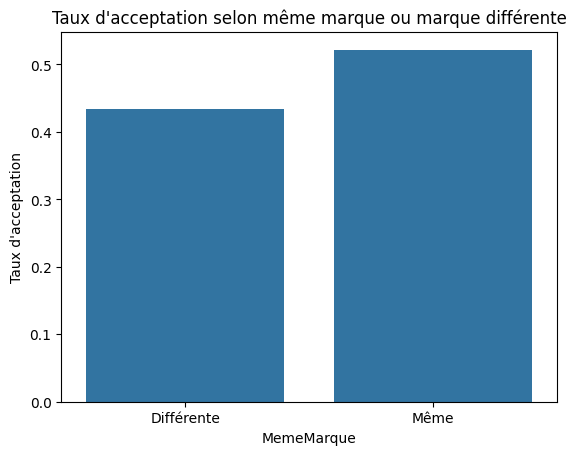

In [35]:
# Taux d'acceptation selon même marque ou marque différente
taux_marque = transactions_avec_substitution.groupby("MemeMarque")["estAcceptee"].mean().reset_index()

sns.barplot(x="MemeMarque", y="estAcceptee", data=taux_marque)
plt.xticks([0,1], ['Différente', 'Même'])
plt.ylabel("Taux d'acceptation")
plt.title("Taux d'acceptation selon même marque ou marque différente")
plt.show()

Effet de substitution au sein de la même marque
- La marque joue un rôle important dans l’acceptation(taux d’acceptation de 52% vs 43% pour une substitution hors marque).
- Les clients semblent attachés à la marque qu’ils voulaient initialement.

-> Une substitution de même marque inspire davantage confiance et réduit la “distance perçue” entre l’attendu et la proposition.

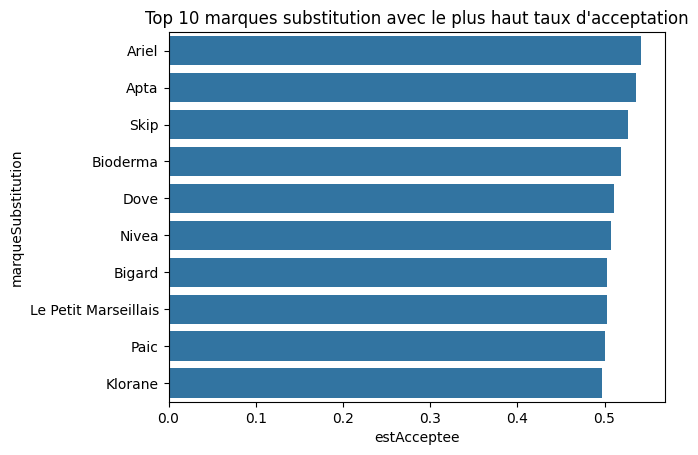

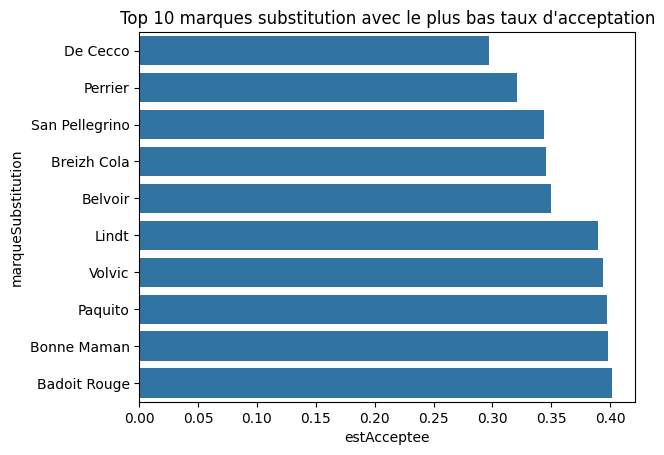

In [36]:

# Top 10 / Bottom 10 marques substitution
marque_accept = transactions_avec_substitution.groupby("marqueSubstitution")["estAcceptee"].mean().reset_index()
top10 = marque_accept.sort_values("estAcceptee", ascending=False).head(10)
bottom10 = marque_accept.sort_values("estAcceptee").head(10)

sns.barplot(x="estAcceptee", y="marqueSubstitution", data=top10)
plt.title("Top 10 marques substitution avec le plus haut taux d'acceptation")
plt.show()

sns.barplot(x="estAcceptee", y="marqueSubstitution", data=bottom10)
plt.title("Top 10 marques substitution avec le plus bas taux d'acceptation")
plt.show()

Marque avec les meilleurs taux d’acceptation
- On observe que certaines marques universellement connues et perçues comme fiables (Ariel, Skip, Dove, Le Petit Marseillais, etc.) affichent les meilleurs taux d’acceptation (>50%) -> Ce sont souvent des marques nationales premium ou très installées avec une forte notoriété.
- Le client est moins réticent à remplacer son produit original par une marque reconnue pour sa qualité ou son efficacité.

Marque avec les plus faibles taux d’acceptation
- Certaines marques, pourtant très connues (Perrier, San Pellegrino, Lindt, Volvic, Bonne Maman…), affichent des taux d’acceptation nettement plus faibles (≈ 30–40%).
- Ces marques ont probablement un positionnement très identitaire :
Goût très spécifique (Perrier, San Pellegrino, Breizh Cola)
, produit perçu comme premium ou “plaisir” (Lindt, Bonne Maman)
 ou forte différenciation sensorielle (Belvoir, Volvic)

##### Marque originale vs marque de substitution

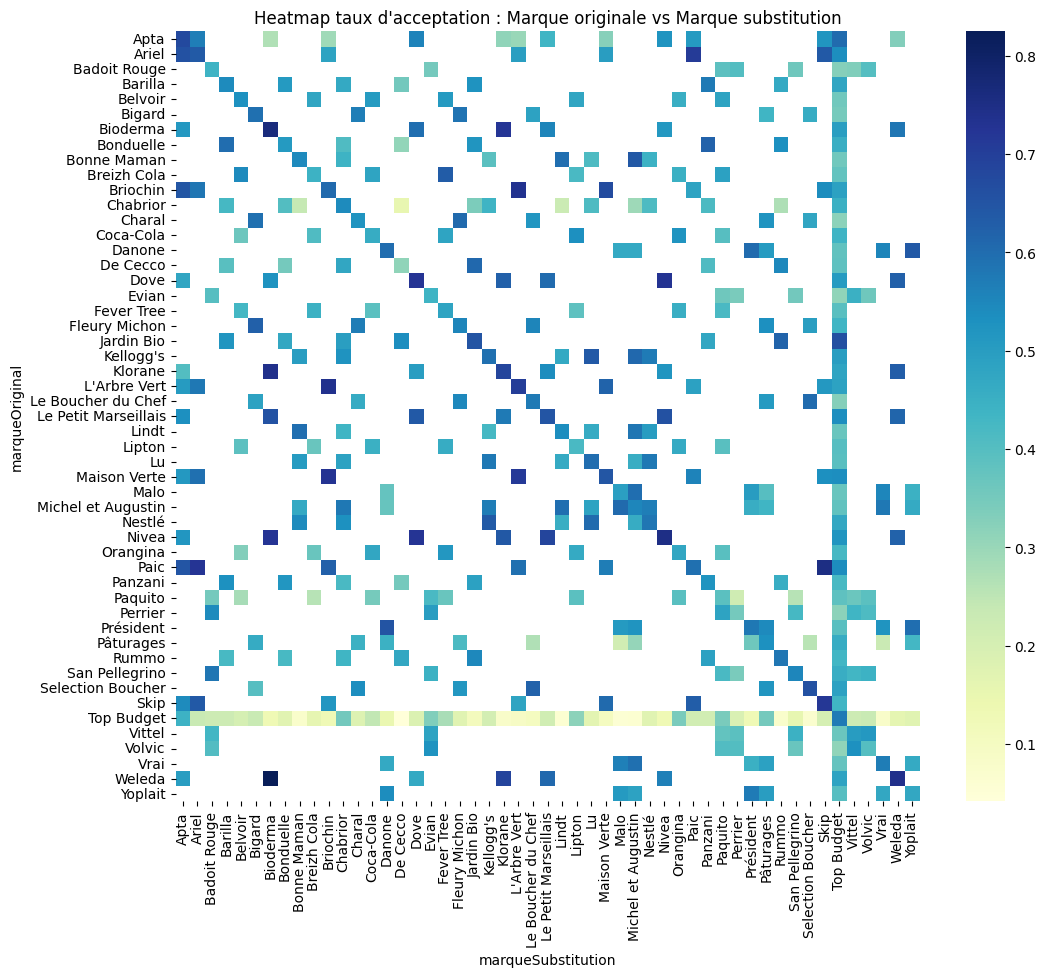

In [37]:
# Heatmap Marque Originale × Marque Substitution
pivot_marque = transactions_avec_substitution.pivot_table(
    index="marqueOriginal",
    columns="marqueSubstitution",
    values="estAcceptee",
    aggfunc="mean"
)
plt.figure(figsize=(12,10))
sns.heatmap(pivot_marque, cmap="YlGnBu")
plt.title("Heatmap taux d'acceptation : Marque originale vs Marque substitution")
plt.show()

La réticence des clients à accepter des substitutions dépend fortement de la marque.
- Les produits de marques génériques ou du quotidien sont plus facilement interchangés.
- Les marques ayant une forte différenciation sensorielle ou identitaire ont tendance à être moins acceptées lorsqu'elles sont substituées.
- Les marques avec une identité forte (par exemple, Perrier, San Pellegrino) peuvent avoir des taux d'acceptation plus faibles pour les substitutions (zones plus claires), en raison des préférences spécifiques des clients envers ces marques bien établies.
- Les grandes marques universellement connues, comme Dove ou Ariel, auront des taux d'acceptation de substitution plus élevés en général, même si elles sont substituées par un produit d’une autre marque connue.


#### 2.2. Effet du prix sur le taux d’acceptation

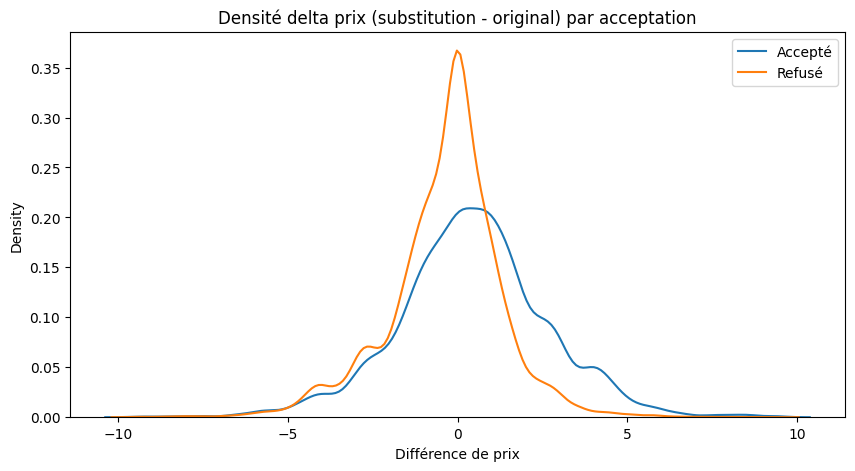

Médianes DiffPrix : accepté = 0.43000000000000016, refusé = -0.14999999999999947


In [38]:
# Distribution du delta prix selon acceptation
plt.figure(figsize=(10,5))
sns.kdeplot(
    transactions_avec_substitution.loc[transactions_avec_substitution['estAcceptee_bin']==1, 'DiffPrix'].dropna(),
    label='Accepté', bw_adjust=1.2
)
sns.kdeplot(
    transactions_avec_substitution.loc[transactions_avec_substitution['estAcceptee_bin']==0, 'DiffPrix'].dropna(),
    label='Refusé', bw_adjust=1.2
)
plt.legend()
plt.title("Densité delta prix (substitution - original) par acceptation")
plt.xlabel("Différence de prix")
plt.show()

# Médianes
med_accepted = transactions_avec_substitution.loc[transactions_avec_substitution['estAcceptee_bin']==1,'DiffPrix'].median()
med_refused = transactions_avec_substitution.loc[transactions_avec_substitution['estAcceptee_bin']==0,'DiffPrix'].median()
print(f"Médianes DiffPrix : accepté = {med_accepted}, refusé = {med_refused}")

Les courbes se chevauchent beaucoup autour de zéro, donc beaucoup de substitutions sont acceptées même avec une différence de prix légère.

Cependant, il y a une légère tendance à accepter des substituts légèrement plus chers et à refuser ceux légèrement moins chers, ce qui peut paraître contre-intuitif, mais peut s’expliquer par d’autres facteurs (marque, Nutriscore, conditionnement, perception qualitative).

--> les clients tolèrent ou même acceptent un petit surcoût pour un produit substitut.

##

#### 2.3. Effet du Nutriscore sur le taux d’acceptation

Nutriscore a un effet sur l’acceptation, plus marqué que le delta prix : les consommateurs sont plus enclins à accepter un substitut qui ne dégrade pas la qualité nutritionnelle.

Les différences ne sont pas énormes, mais elles montrent une préférence pour les substituts égaux ou meilleurs en Nutriscore.

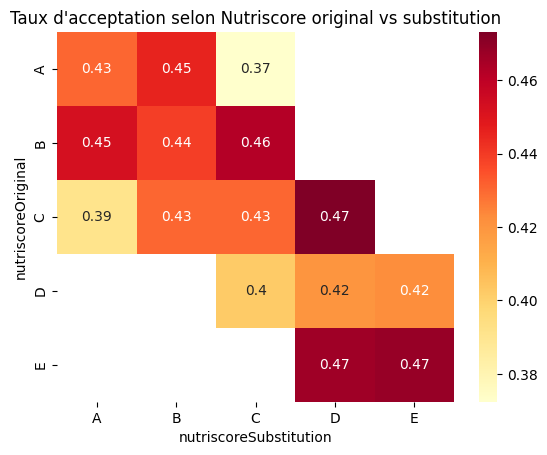

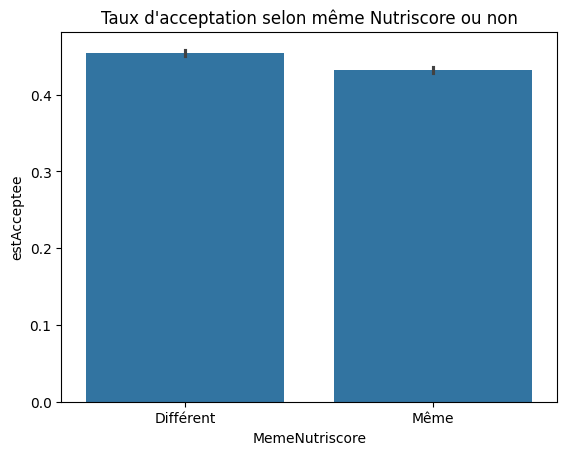

In [39]:
# Heatmap Nutriscore Original vs Substitution
pivot_nutri = transactions_avec_substitution.pivot_table(
    index="nutriscoreOriginal",
    columns="nutriscoreSubstitution",
    values="estAcceptee",
    aggfunc="mean"
)
sns.heatmap(pivot_nutri, annot=True, cmap="YlOrRd")
plt.title("Taux d'acceptation selon Nutriscore original vs substitution")
plt.show()

# Boxplot MemeNutriscore
sns.barplot(x="MemeNutriscore", y="estAcceptee", data=transactions_avec_substitution)
plt.xticks([0,1], ['Différent', 'Même'])
plt.title("Taux d'acceptation selon même Nutriscore ou non")
plt.show()

#### 2.4. Effet du Bio sur le taux d’acceptation

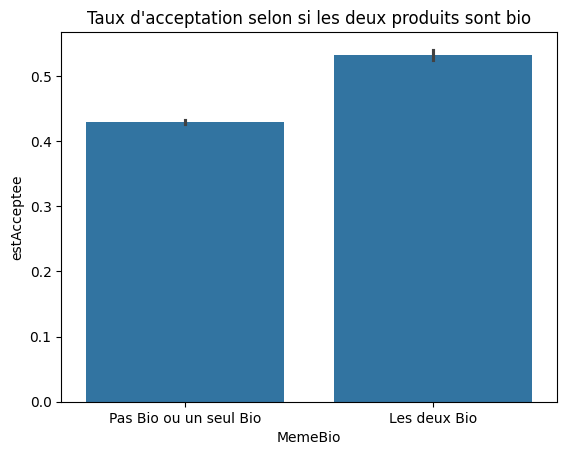

In [32]:
sns.barplot(x="MemeBio", y="estAcceptee", data=transactions_avec_substitution)
plt.xticks([0,1], ['Pas Bio ou un seul Bio', 'Les deux Bio'])
plt.title("Taux d'acceptation selon si les deux produits sont bio")
plt.show()

## 3. Preprocessing des données numériques et catégorielles

Dans le processus de préparation des données pour le modèle de classification, plusieurs étapes de preprocessing sont nécessaires pour gérer les variables numériques et catégorielles.

Définir la cible et les features :
- La cible (y) est définie comme la variable estAcceptee_bin issue des transactions.
- Les features sont divisées en numériques (features_num) et catégorielles (features_cat), influençant le choix du preprocessing.

Séparation des données :
- Séparation temporaire des données en ensembles d’entraînement et de test (80/20) avant toute transformation, permettant une généralisation correcte des modèles.

Transformation des valeurs numériques :
- Imputation : Remplacer les valeurs nulles par la médiane avec SimpleImputer.
Standardisation : Normaliser les données numériques avec StandardScaler pour les mettre sur une échelle similaire.

Traitement des variables catégorielles :
- Imputation : Remplacer les valeurs nulles avec la modalité la plus fréquente.
- Encodage : Convertir les catégories en indicateurs numériques avec OneHotEncoder, gérant les catégories inconnues.

Application du préprocessing :
- ColumnTransformer compile les transformations pour appliquer séparément aux variables numériques et catégorielles.
- Le fit est réalisé sur les données d’entraînement, et la transformation est appliquée à la fois sur les jeux de données d’entraînement et de test.

In [14]:
# 1) Définir la cible
y = transactions_avec_substitution["estAcceptee_bin"]

# 2) Définir les features
features_num = [
    "DiffPrix",
    "MemeMarque",
    "MemeNutriscore",
    "MemeBio",
    "prixOriginal",
 #   "prixSubstitution",
    "MemeConditionnement",
    "MemeTypeMarque",
    "estBioOriginal",
    "Month",
]

features_cat = [
    "categorieOriginal",
    "marqueOriginal",
    "typeMarqueOriginal",
    "nutriscoreOriginal",
    "origineOriginal",
    "conditionnementOriginal",
    "categorieSubstitution",
 #  "marqueSubstitution",
    "typeMarqueSubstitution",
 #  "nutriscoreSubstitution",
    "origineSubstitution",
 #  "estBioSubstitution",
#  "conditionnementSubstitution",
    "Day_of_week_name",
]

X = transactions_avec_substitution[features_num + features_cat]

# 3) Split temporel AVANT fit du préprocessing
cutoff_idx = int(len(transactions_avec_substitution) * 0.8)
X_train_raw, X_test_raw = X.iloc[:cutoff_idx], X.iloc[cutoff_idx:]
y_train, y_test = y.iloc[:cutoff_idx], y.iloc[cutoff_idx:]
                                              
# 4) Imputation des valeurs nulles et encodage des variables catégorielles
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown='ignore')),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, features_num),
        ("cat", categorical_transformer, features_cat),
    ]
)

# Fit du preprocessing sur le train et transform le test
X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

## 4. Feature importance via un modèle de baseline (Random Forest)

In [ ]:
# Modèle (entraîné sur les données déjà prétraitées)
rf = RandomForestClassifier(
    n_estimators=150,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample",
)

rf.fit(X_train, y_train)

# 8) Entraînement
rf.fit(X_train, y_train)

# 9) Importance des features
rf_model = rf
ohe = preprocessor.named_transformers_["cat"]
# noms des colonnes numériques (inchangés)
num_feature_names = features_num
# noms des colonnes catégorielles après one‑hot
cat_feature_names = ohe.get_feature_names_out(features_cat)

# concat de tous les noms de colonnes après prétraitement
all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

# importances du random forest
importances = rf_model.feature_importances_



In [59]:
# 10) Mettre dans un DataFrame et agréger par feature « logique »

feat_imp = pd.DataFrame(
    {"feature_encoded": all_feature_names, "importance": importances}
).sort_values("importance", ascending=False)

# Regrouper par feature d’origine (avant one‑hot)
feat_imp["feature"] = feat_imp["feature_encoded"].str.split("_", n=1).str[0]
feat_imp_grouped = (
    feat_imp.groupby("feature")["importance"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

/tmp/ipykernel_25272/3289457405.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


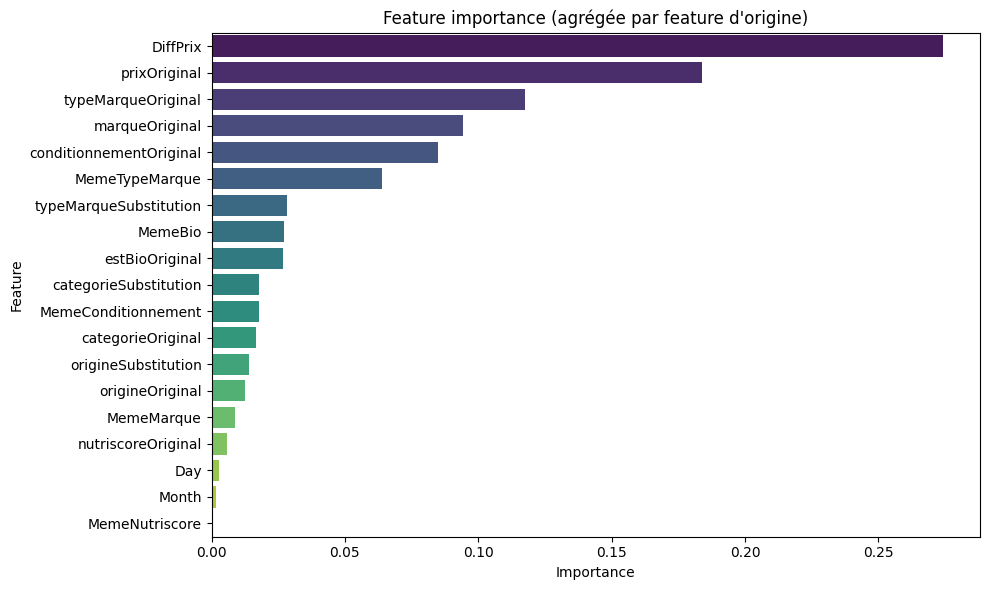

In [60]:
# On part de feat_imp_grouped calculé juste au-dessus
top_k = 20
top_feat = feat_imp_grouped.head(top_k)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_feat,
    x="importance",
    y="feature",
    palette="viridis"
)
plt.title("Feature importance (agrégée par feature d'origine)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Importance du prix :
- DiffPrix et prixOriginal restent les caractéristiques les plus influentes, soulignant que la différence de prix et le prix d'origine sont cruciaux pour l'acceptation des substitutions.

Identité de la marque :
- marqueOriginal et typeMarqueOriginal démontrent que l'attachement à la marque d'origine influence fortement la décision des consommateurs.

Correspondance des caractéristiques de substitution :
- MemeTypeMarque : Un remplacement avec le même type de marque favorise l'acceptation, suggérant que la familiarité avec le type de produit rassure les consommateurs.
- MemeBio: Indique que la substitution par un produit biologique similaire est également bien acceptée, reflétant une préférence pour les attributs de qualité perçus.
- MemeConditionnement : Montre que le format de conditionnement similaire encourage l'acceptation, car les consommateurs préfèrent des produits qu'ils reconnaissent facilement.

Facteurs d'identité :
- Des caractéristiques comme estBio, categorieSubstitution, et origineSubstitution ont une importance modérée, soulignant que ces éléments sont pertinents, mais moins déterminants que le prix et l'identité de la marque.

Variables moins influentes :
- Les variables comme Day et Month ont une importance minimale, indiquant que les facteurs temporels ne jouent pas un rôle significatif dans l'acceptation des substitutions.

## 5. Training des modèles de classification

Définition de l'espace d'hyperparamètres :
- On utilise Hyperopt pour définir un espace de recherche pour trois types de modèles : XGBoost, LightGBM et CatBoost. Chaque modèle a des hyperparamètres spécifiques à optimiser, comme le taux d'apprentissage, la profondeur maximale, et le nombre de feuilles.

Fonctions de décodage :
- Des fonctions (decode_xgb, decode_lgb, decode_cat) permettent de transformer les valeurs d'hyperparamètres choisies par Hyperopt en paramètres utilisables pour construire les modèles, assurant que les choix d'indices sont correctement interprétés.

Construction du modèle :
- La fonction build_model_from_params construit les modèles de classification (XGBoost, LightGBM, CatBoost) avec les hyperparamètres décodés, garantissant que chaque modèle est configuré avec les paramètres optimaux.

Objectif de l'optimisation :
- La fonction objective évalue chaque modèle en calculant l'AUC (Area Under the Curve) sur les données de test après l'entraînement, ce qui permet de mesurer la performance des modèles sur la tâche de classification.

Exécution de Hyperopt :
- Hyperopt est ensuite exécuté avec une recherche par essai et erreur (30 évaluations) pour trouver les meilleurs hyperparamètres, stockant les résultats dans trials.

In [15]:
# Espace d'hyperparamètres pour Hyperopt
space = hp.choice("model_type", [
    {
        "type": "xgb",
        "eta": hp.uniform("eta", 0.01, 0.3),
        "max_depth": hp.choice("max_depth_x", [4, 6, 8, 10]),
        "subsample": hp.uniform("subsample_x", 0.6, 1.0),
        "colsample_bytree": hp.uniform("colsample_x", 0.5, 1.0),
        "min_child_weight": hp.uniform("min_child_x", 1, 10),
    },
    {
        "type": "lgb",
        "learning_rate": hp.uniform("learning_rate_l", 0.01, 0.3),
        "max_depth": hp.choice("max_depth_l", [-1, 4, 6, 8]),
        "num_leaves": hp.choice("num_leaves_l", [31, 63, 127]),
        "feature_fraction": hp.uniform("feature_fraction_l", 0.6, 1.0),
        "bagging_fraction": hp.uniform("bagging_fraction_l", 0.6, 1.0),
        "bagging_freq": hp.choice("bagging_freq_l", [0, 1, 5]),
    },
    {
        "type": "cat",
        "learning_rate": hp.uniform("learning_rate_c", 0.01, 0.3),
        "depth": hp.choice("depth_c", [4, 6, 8, 10]),
        "l2_leaf_reg": hp.uniform("l2_leaf_reg_c", 1, 10),
    }
])

# decode helpers (pour reconstruire les meilleurs modèles depuis trials)
_xgb_opts = {"max_depth_x": [4,6,8,10]}
_lgb_opts = {"max_depth_l": [-1,4,6,8], "num_leaves_l": [31,63,127], "bagging_freq_l": [0,1,5]}
_cat_opts = {"depth_c": [4,6,8,10]}

def scalarize(vals):
    return {k: (v[0] if isinstance(v, list) and len(v)==1 else v) for k,v in vals.items()}

def decode_xgb(vals):
    p = scalarize(vals)
    return {
        "eta": p.get("eta"),
        "max_depth": _xgb_opts["max_depth_x"][int(p.get("max_depth_x",0))] if "max_depth_x" in p else None,
        "subsample": p.get("subsample_x"),
        "colsample_bytree": p.get("colsample_x"),
        "min_child_weight": p.get("min_child_x"),
    }

def decode_lgb(vals):
    p = scalarize(vals)
    return {
        "learning_rate": p.get("learning_rate_l"),
        "max_depth": _lgb_opts["max_depth_l"][int(p.get("max_depth_l",0))] if "max_depth_l" in p else None,
        "num_leaves": _lgb_opts["num_leaves_l"][int(p.get("num_leaves_l",0))] if "num_leaves_l" in p else None,
        "feature_fraction": p.get("feature_fraction_l"),
        "bagging_fraction": p.get("bagging_fraction_l"),
        "bagging_freq": _lgb_opts["bagging_freq_l"][int(p.get("bagging_freq_l",0))] if "bagging_freq_l" in p else None,
    }

def decode_cat(vals):
    p = scalarize(vals)
    return {
        "learning_rate": p.get("learning_rate_c"),
        "depth": _cat_opts["depth_c"][int(p.get("depth_c",0))] if "depth_c" in p else None,
        "l2_leaf_reg": p.get("l2_leaf_reg_c"),
    }

# construction centralisée de modèles (utilise les decode_*)
def build_model_from_params(model_type, vals, random_state=42):
    if model_type == "xgb":
        params = decode_xgb(vals)
        return xgb.XGBClassifier(
            n_estimators=100,
            eval_metric="logloss",
            tree_method="hist",
            use_label_encoder=False,
            eta=params.get("eta"),
            max_depth=int(params.get("max_depth")) if params.get("max_depth") is not None else 6,
            subsample=params.get("subsample"),
            colsample_bytree=params.get("colsample_bytree"),
            min_child_weight=params.get("min_child_weight"),
            random_state=random_state
        )
    if model_type == "lgb":
        params = decode_lgb(vals)
        return lgb.LGBMClassifier(
            n_estimators=100,
            verbose=-1,
            learning_rate=params.get("learning_rate"),
            max_depth=int(params.get("max_depth")) if params.get("max_depth") is not None else -1,
            num_leaves=int(params.get("num_leaves")) if params.get("num_leaves") is not None else 31,
            feature_fraction=params.get("feature_fraction"),
            bagging_fraction=params.get("bagging_fraction"),
            bagging_freq=int(params.get("bagging_freq")) if params.get("bagging_freq") is not None else 0,
            random_state=random_state
        )
    # catboost
    params = decode_cat(vals)
    return CatBoostClassifier(
        iterations=100,
        verbose=False,
        learning_rate=params.get("learning_rate"),
        depth=int(params.get("depth")) if params.get("depth") is not None else 6,
        l2_leaf_reg=params.get("l2_leaf_reg"),
        random_state=random_state
    )

# objective : utilise build_model_from_params
def objective(params):
    model_type = params["type"]
    params = dict(params)
    del params["type"]
    model = build_model_from_params(model_type, params, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_test)[:, 1]
    score = roc_auc_score(y_test, preds)
    return {"loss": -score, "status": STATUS_OK}

# Run Hyperopt
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=30, trials=trials)

# extra maps
idx_to_type = {0: "xgb", 1: "lgb", 2: "cat"}
idx_to_label = {0: "XGBOOST", 1: "LIGHTGBM", 2: "CATBOOST"}


  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

  3%|▎         | 1/30 [00:01<00:29,  1.02s/trial, best loss: -0.7264092814734697]

/home/emna/.pyenv/versions/intermarche/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



  7%|▋         | 2/30 [00:03<00:46,  1.65s/trial, best loss: -0.7264092814734697]

/home/emna/.pyenv/versions/intermarche/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [10:55:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 20%|██        | 6/30 [00:09<00:36,  1.52s/trial, best loss: -0.7264092814734697]

/home/emna/.pyenv/versions/intermarche/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 27%|██▋       | 8/30 [00:12<00:30,  1.40s/trial, best loss: -0.7264092814734697]

/home/emna/.pyenv/versions/intermarche/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

/home/emna/.pyenv/versions/intermarche/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [10:55:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 37%|███▋      | 11/30 [00:15<00:25,  1.33s/trial, best loss: -0.7264092814734697]

/home/emna/.pyenv/versions/intermarche/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 40%|████      | 12/30 [00:16<00:21,  1.21s/trial, best loss: -0.7264092814734697]

/home/emna/.pyenv/versions/intermarche/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

/home/emna/.pyenv/versions/intermarche/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [10:55:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 47%|████▋     | 14/30 [00:18<00:16,  1.06s/trial, best loss: -0.7272033265633397]

/home/emna/.pyenv/versions/intermarche/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

/home/emna/.pyenv/versions/intermarche/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [10:55:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 50%|█████     | 15/30 [00:19<00:15,  1.02s/trial, best loss: -0.7272033265633397]

/home/emna/.pyenv/versions/intermarche/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [10:55:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 60%|██████    | 18/30 [00:23<00:13,  1.15s/trial, best loss: -0.7272033265633397]

/home/emna/.pyenv/versions/intermarche/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 67%|██████▋   | 20/30 [00:25<00:11,  1.18s/trial, best loss: -0.7272033265633397]

/home/emna/.pyenv/versions/intermarche/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

/home/emna/.pyenv/versions/intermarche/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [10:55:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 70%|███████   | 21/30 [00:26<00:10,  1.12s/trial, best loss: -0.7272033265633397]

/home/emna/.pyenv/versions/intermarche/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [10:55:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 73%|███████▎  | 22/30 [00:27<00:08,  1.07s/trial, best loss: -0.7272033265633397]

/home/emna/.pyenv/versions/intermarche/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [10:55:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 77%|███████▋  | 23/30 [00:28<00:07,  1.05s/trial, best loss: -0.7275967350373624]

/home/emna/.pyenv/versions/intermarche/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [10:55:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 80%|████████  | 24/30 [00:29<00:06,  1.01s/trial, best loss: -0.7275967350373624]

/home/emna/.pyenv/versions/intermarche/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [10:55:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 83%|████████▎ | 25/30 [00:30<00:04,  1.04trial/s, best loss: -0.7275967350373624]

/home/emna/.pyenv/versions/intermarche/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [10:55:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 87%|████████▋ | 26/30 [00:31<00:03,  1.04trial/s, best loss: -0.7275967350373624]

/home/emna/.pyenv/versions/intermarche/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [10:56:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 90%|█████████ | 27/30 [00:32<00:02,  1.03trial/s, best loss: -0.7275967350373624]

/home/emna/.pyenv/versions/intermarche/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [10:56:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 93%|█████████▎| 28/30 [00:33<00:01,  1.04trial/s, best loss: -0.7275967350373624]

/home/emna/.pyenv/versions/intermarche/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [10:56:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 97%|█████████▋| 29/30 [00:34<00:01,  1.02s/trial, best loss: -0.727610909094216] 

/home/emna/.pyenv/versions/intermarche/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [10:56:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



100%|██████████| 30/30 [00:35<00:00,  1.20s/trial, best loss: -0.727610909094216]


Pourquoi on a choisi ces modèles de classification?

XGBoost : 
- Très performant pour les problèmes de classification. Il gère bien les données déséquilibrées et offre une excellente capacité de régularisation.

LightGBM : 
- Connu pour sa rapidité et son efficacité sur des ensembles de données volumineux. Optimisé pour l'utilisation de la mémoire, il est idéal pour le traitement de grands volumes de données.

CatBoost : 
-Excellente option pour travailler avec des variables catégorielles sans nécessiter un prétraitement complexe. Il est robuste et très performant sur une variété de jeux de données.

## 6. Evaluation des performances des modèles de classification

/home/emna/.pyenv/versions/intermarche/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [09:36:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/emna/.pyenv/versions/intermarche/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


      Model Dataset  Accuracy       AUC  Precision    Recall        F1
0   XGBOOST   Train  0.673272  0.743021   0.705538  0.709647  0.707587
1   XGBOOST    Test  0.661374  0.727397   0.694551  0.699653  0.697092
2  LIGHTGBM   Train  0.705380  0.785619   0.740585  0.725103  0.732762
3  LIGHTGBM    Test  0.656976  0.720862   0.695946  0.682041  0.688923
4  CATBOOST   Train  0.668521  0.733471   0.699483  0.709963  0.704684
5  CATBOOST    Test  0.662694  0.728215   0.693783  0.705892  0.699785


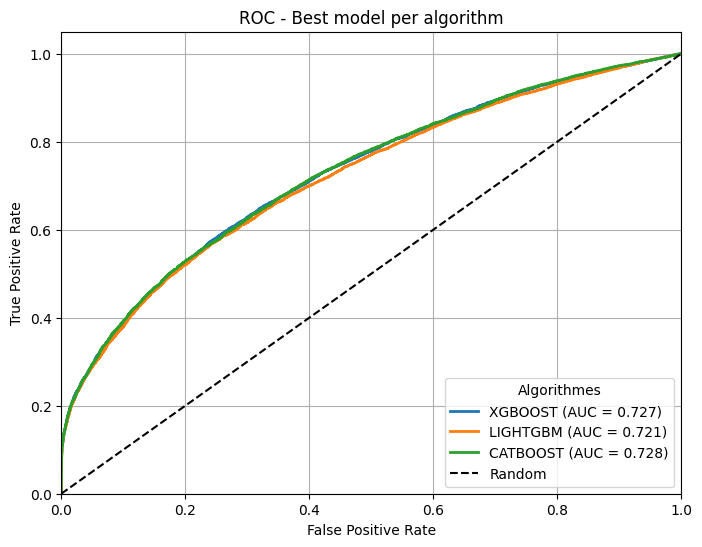

In [103]:
# métriques utilitaires
def safe_auc(y_true, y_score):
    try:
        if len(np.unique(y_true)) < 2:
            return np.nan
        return roc_auc_score(y_true, y_score)
    except Exception:
        return np.nan

def compute_metrics_for_model(model, X_train, y_train, X_test, y_test, thr=0.5):
    model.fit(X_train, y_train)
    probs_train = model.predict_proba(X_train)[:, 1]
    probs_test = model.predict_proba(X_test)[:, 1]
    preds_train = (probs_train > thr).astype(int)
    preds_test = (probs_test > thr).astype(int)

    fpr, tpr, _ = roc_curve(y_test, probs_test)
    roc_auc = auc(fpr, tpr)

    return {
        "Accuracy_Train": accuracy_score(y_train, preds_train),
        "Accuracy_Test": accuracy_score(y_test, preds_test),
        "AUC_Train": safe_auc(y_train, probs_train),
        "AUC_Test": safe_auc(y_test, probs_test),
        "Precision_Train": precision_score(y_train, preds_train, zero_division=0),
        "Precision_Test": precision_score(y_test, preds_test, zero_division=0),
        "Recall_Train": recall_score(y_train, preds_train, zero_division=0),
        "Recall_Test": recall_score(y_test, preds_test, zero_division=0),
        "F1_Train": f1_score(y_train, preds_train, zero_division=0),
        "F1_Test": f1_score(y_test, preds_test, zero_division=0),
        "fpr": fpr, "tpr": tpr, "roc_auc": roc_auc
    }

# Trouver le meilleur essai par algorithme
best_vals_per_model = {}
for t in trials.trials:
    vals = t.get("misc", {}).get("vals", {})
    mt = vals.get("model_type")
    if not mt:
        continue
    model_idx = int(mt[0])
    loss = t.get("result", {}).get("loss", np.inf)
    if loss is None:
        loss = np.inf
    if model_idx not in best_vals_per_model or loss < best_vals_per_model[model_idx]["loss"]:
        best_vals_per_model[model_idx] = {"loss": loss, "vals": vals}

# Évaluer et tracer les ROC + construire le DataFrame de performance
roc_entries = []
rows = []
for model_idx in sorted(idx_to_type.keys()):
    label = idx_to_label[model_idx]
    info = best_vals_per_model.get(model_idx)
    if info is None:
        rows.append({"Model": label, "Dataset": "Train", "Accuracy": np.nan, "AUC": np.nan, "Precision": np.nan, "Recall": np.nan, "F1": np.nan})
        rows.append({"Model": label, "Dataset": "Test",  "Accuracy": np.nan, "AUC": np.nan, "Precision": np.nan, "Recall": np.nan, "F1": np.nan})
        continue

    vals = info["vals"]
    model_type = idx_to_type[model_idx]
    model = build_model_from_params(model_type, vals, random_state=42)
    met = compute_metrics_for_model(model, X_train, y_train, X_test, y_test)

    rows.append({"Model": label, "Dataset": "Train", "Accuracy": met["Accuracy_Train"], "AUC": met["AUC_Train"],
                 "Precision": met["Precision_Train"], "Recall": met["Recall_Train"], "F1": met["F1_Train"]})
    rows.append({"Model": label, "Dataset": "Test",  "Accuracy": met["Accuracy_Test"],  "AUC": met["AUC_Test"],
                 "Precision": met["Precision_Test"], "Recall": met["Recall_Test"], "F1": met["F1_Test"]})

    roc_entries.append((met["fpr"], met["tpr"], met["roc_auc"], label))

performance_df = pd.DataFrame(rows)[["Model", "Dataset", "Accuracy", "AUC", "Precision", "Recall", "F1"]]
print(performance_df)

plt.figure(figsize=(8,6))
for fpr, tpr, roc_auc, label in roc_entries:
    plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC = {roc_auc:.3f})")
plt.plot([0,1],[0,1], linestyle="--", color="k", label="Random")
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC - Best model per algorithm")
plt.legend(loc="lower right", title="Algorithmes")
plt.grid(True)
plt.show()

## 7. Interprétabilité des modèles via SHAP

Best XGBOOST found with loss = -0.727610909094216


/home/emna/.pyenv/versions/intermarche/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [13:34:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


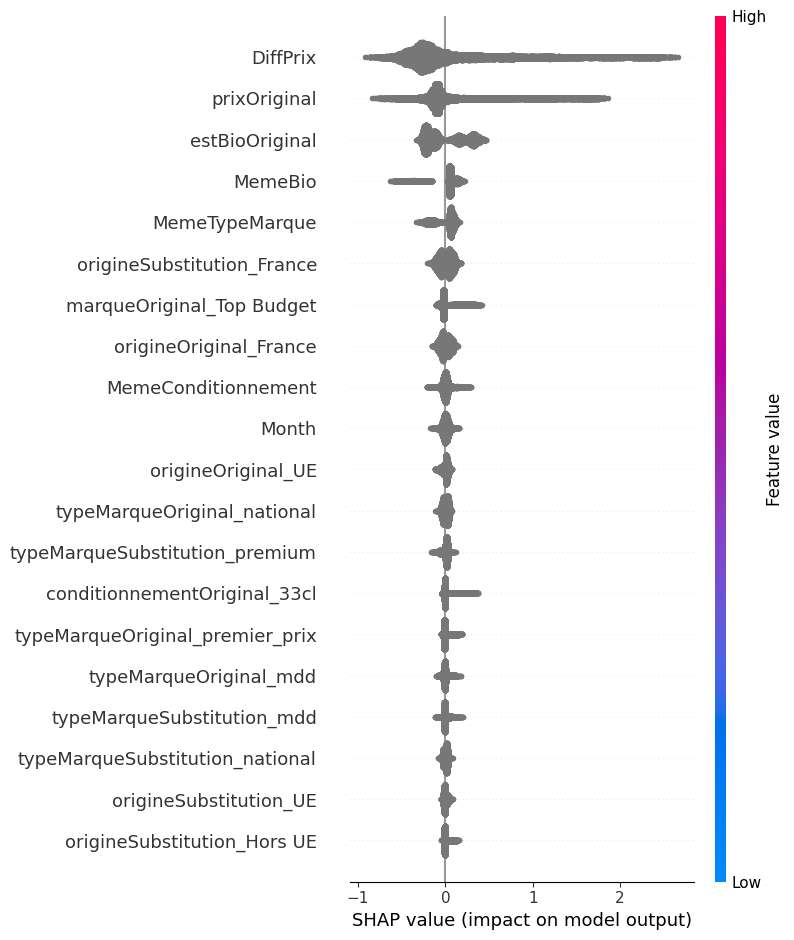

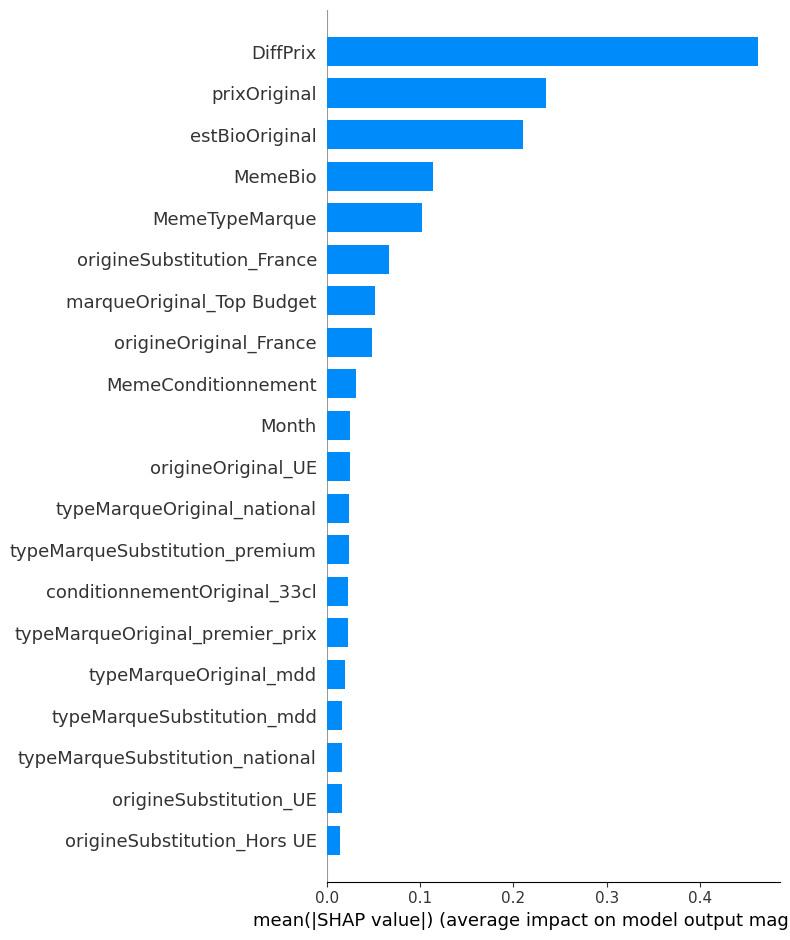

In [21]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# 1) Retrouver le meilleur essai XGBOOST
best_xgb_loss = np.inf
best_xgb_vals = None

for t in trials.trials:
    vals = t["misc"]["vals"]
    model_idx = int(vals["model_type"][0])   # 0 = XGB, 1 = LGB, 2 = CAT
    if model_idx != 0:
        continue  # on ne garde QUE XGBoost

    loss = t["result"]["loss"]
    if loss < best_xgb_loss:
        best_xgb_loss = loss
        best_xgb_vals = vals

print("Best XGBOOST found with loss =", best_xgb_loss)

# 2) Reconstruction du meilleur modèle XGBoost
best_xgb_model = build_model_from_params("xgb", best_xgb_vals, random_state=42)

# 3) Entraînement complet
best_xgb_model.fit(X_train, y_train)

# 4) SHAP Explainer (TreeExplainer pour XGBoost)
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_test)

# -------------------------------------------------------
# Récupération des noms de features après preprocessing
# -------------------------------------------------------

# 1) Noms des variables numériques (inchangés)
num_feature_names = features_num  

# 2) Noms des variables catégorielles encodées
cat_feature_names = (
    preprocessor.named_transformers_["cat"]
        .named_steps["onehot"]
        .get_feature_names_out(features_cat)
)

# 3) Concaténer pour obtenir la liste finale
feature_names = list(num_feature_names) + list(cat_feature_names)

# -------------------------------------------------------
# 5) SUMMARY PLOT — Importance globale des features
# -------------------------------------------------------
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

# -------------------------------------------------------
# 6) BAR PLOT — Importance moyenne absolue
# -------------------------------------------------------
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar")

# # -------------------------------------------------------
# # 7) WATERFALL PLOT — Interprétation d’une prédiction individuelle
# # -------------------------------------------------------
# idx = 0  # première observation du test set

# shap.plots.waterfall(
#     shap.Explanation(
#         values=shap_values[idx],
#         base_values=explainer.expected_value,
#         data=X_test.[idx],
#         feature_names=feature_names,
#     )
# )


Interprétation des valeurs SHAP

Impact des caractéristiques :
- Les valeurs SHAP mesurent l'impact de chaque caractéristique sur la sortie du modèle. Chaque point le long de l'axe horizontal représente une instance, montrant comment chaque feature contribue à la prédiction.

Caractéristique la plus influente :
- DiffPrix est la caractéristique la plus importante, avec des valeurs élevées sur l'axe, indiquant que la différence de prix joue un rôle crucial dans la décision d'acceptation des substitutions. Cela signifie que les variations de prix influencent fortement le résultat du modèle.

Autres caractéristiques influentes :
- prixOriginal et estBioOriginal ont également un impact significatif. Cela montre que le prix d'origine et le fait que le produit soit bio affectent également les décisions des consommateurs.
MemeBio et MemeTypeMarque sont des caractéristiques clés, indiquant que la conformité avec le type de produit (bio ou marque) a une importance notable pour l'acceptation.

Influence des caractéristiques contextuelles :
- origineSubstitution et ses variantes (par exemple, origineSubstitution_Top_Budget) montrent que les aspects d'origine des produits substitués impactent également les décisions, suggérant une sensibilité à la provenance des produits.

Caractéristiques moins influentes :
- Certaines caractéristiques, comme Month ou divers types de marques (par exemple, typeMarqueOriginal_Hors UE), semblent avoir un impact moindre, comme le montrent leurs valeurs SHAP plus proches de zéro. Cela signifie qu'elles contribuent moins aux décisions de substitution.